In [1]:

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt


import pickle as pkl
from utils import *

import pandas as pd
import seaborn as sns

import cartopy.crs as ccrs


In [2]:
n_modes = 5 # select number of modes
modes = 1 + np.arange(n_modes) #for plotting

scenarios = [585, 370, 245, 126] # look at all scenarios

# load DMDc modes from files
dmdcs_hankel = {}
for ssp in scenarios:
    with open(f'./models/DMDc-hankelforcing/tas{ssp}.pkl', 'rb') as f:
        dmdc = pkl.load(f)
        dmdcs_hankel[ssp] = dmdc


#######

# load example dataset
# historical, then scenarios
xr_train_clim = xr.open_dataset('./data/train_val/outputs_historical.nc').mean(dim='member')
xr_test_clim = xr.open_dataset(f'./data/train_val/outputs_ssp126.nc').mean(dim='member')

# stack into xarray dataset
tas_all = xr.concat([xr_train_clim, xr_test_clim], dim = 'time').tas
lat_data = tas_all.lat # store latitude data
lon_data = tas_all.lon # store longitude data


# a small change to plotting function
plotmap = lambda mode, ax, amax: make_plot(mode, lat_data, lon_data, fig, ax, mode_num=0,
                                           min_val=-amax, max_val=amax, colorbar=True)


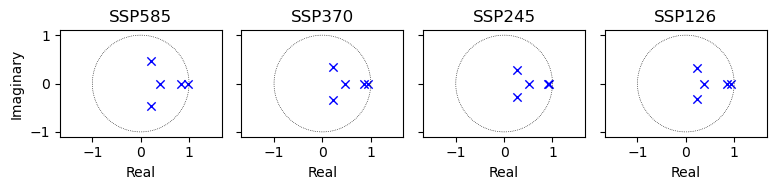

In [3]:
### EIGENVAUE PLOTS

# initialize plot
fig, ax = plt.subplots(1,4, figsize=(8,2), sharey = True)

# loop through each scenario
for i, (ssp, dmd) in enumerate(dmdcs_hankel.items()):
    
    # plot eigenvalues
    ax[i].scatter(np.real(dmd.eigs), np.imag(dmd.eigs), marker = 'x', color = 'blue', lw = 1)
    ax[i].set_xlim([-1,1])
    ax[i].set_ylim([-1,1])
    ax[i].axis('equal')
    ax[i].set_title(f'SSP{ssp}')
    theta = np.linspace(0, 2*np.pi, 100)

    # Parametric equations for the unit circle
    x = np.cos(theta)
    y = np.sin(theta)
    ax[i].plot(x,y,c = 'k', lw = .5, linestyle = 'dotted')
    ax[i].set_xlabel('Real')

ax[0].set_ylabel('Imaginary')

plt.tight_layout()

#save the figure
plt.savefig('plots/eigenvalues.pdf')

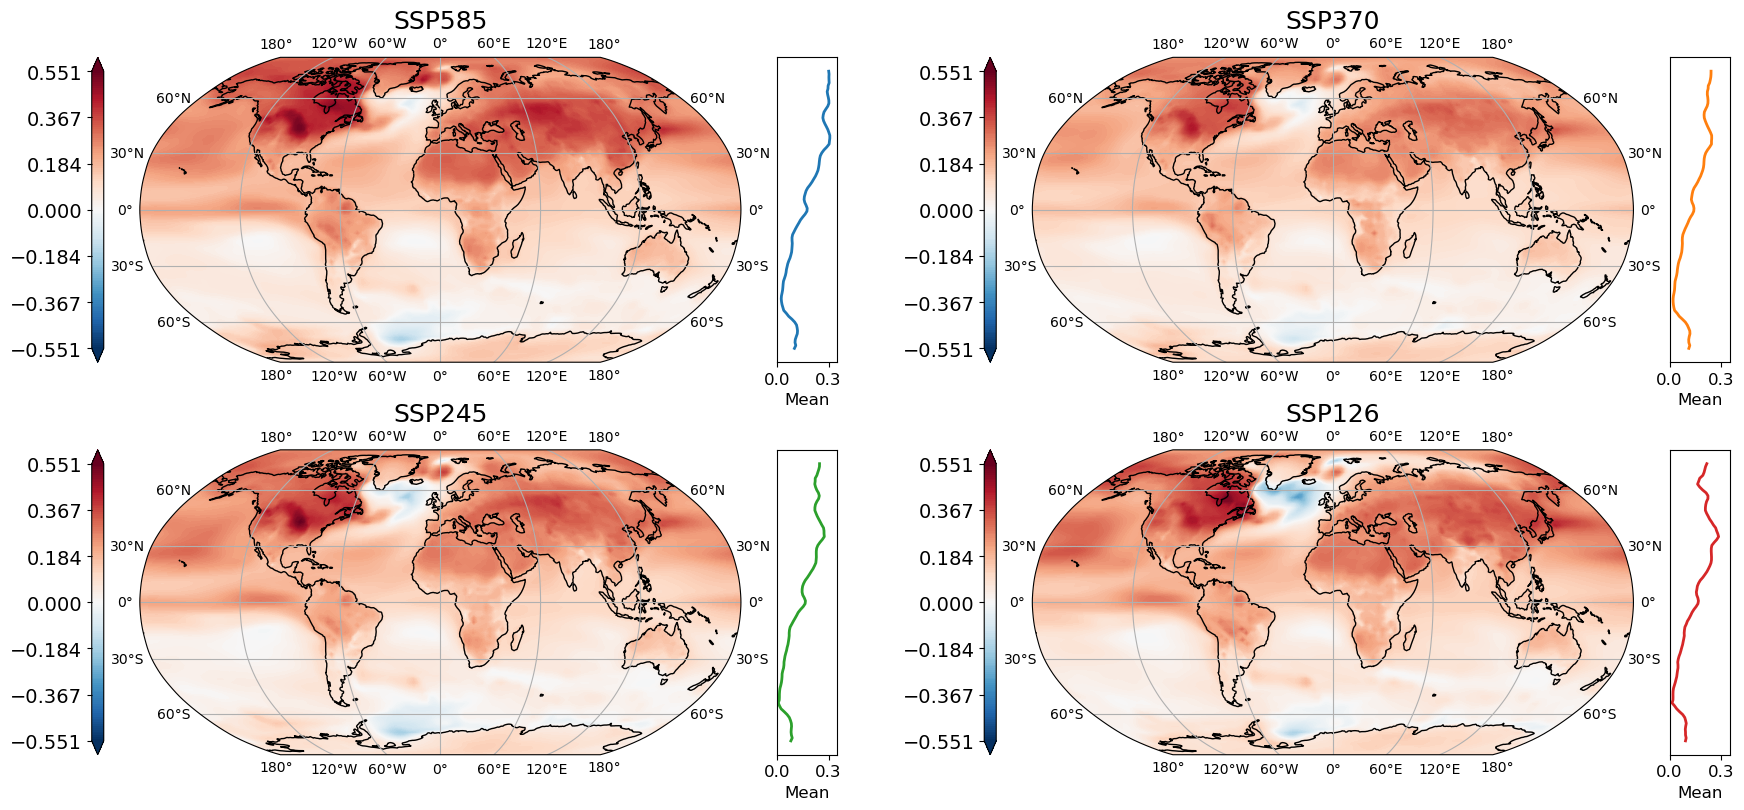

In [4]:
##### WARMING TREND

# initialize plot
fig, ax = plt.subplots(2, 2, figsize=(18,8), 
                       subplot_kw={'projection': ccrs.Robinson()})

# add axis for latitudinal profile
caxs = []
for axi in ax.flatten():
    caxs.append(axi.inset_axes((1.06, 0, 0.1, 1)))

# plot indices
js = [(0,0),(0,1),(1,0),(1,1)]
# colors for plots
colors = ['tab:blue','tab:orange','tab:green','tab:red'] 

# the indices for the scaled modes from the dmdc objects
# found by looking at largest two all-real eigenvalues
mapping = {126: [0,1], 245: [3,4], 370: [2,3], 585: [2,3]}

# loop through each SSP and add latitudinal profile plot
for i, (ssp, mode) in enumerate(dmdcs_hankel.items()):
    X0 = get_real(dmdcs_hankel, ssp, mapping[ssp])
    for j in range(len(js)):
        if i == j:
            # make a solid line for the current ssp
            a = 1
        else:
            # make a transparent line for the other ssp's for comparison
            a = 0
        caxs[j].plot(np.mean(np.real(X0).reshape(96, 144), axis = 1), lat_data, color = colors[i], alpha = a, lw = 2)
        caxs[j].set_yticks([])
        caxs[j].set_xlim([0,.35])
        caxs[j].set_xticks([0,.3])
        caxs[j].set_xlabel('Mean',fontsize=12)
        caxs[j].tick_params(axis='x',labelsize=12)

# loop through each SSP and add spatial plot
amax = max([np.max([get_real(dmdcs_hankel, ssp, mode).max(), -get_real(dmdcs_hankel, ssp, mode).min()]) for (ssp, mode) in mapping.items()])
for i, (ssp, mode) in enumerate(dmdcs_hankel.items()):
    X0 = get_real(dmdcs_hankel, ssp, mapping[ssp])
    plotmap(X0, ax[js[i]], amax)
    ax[js[i]].set_title(f"SSP{ssp}",fontdict = {'fontsize':18})



plt.tight_layout()
plt.savefig('plots/warming_trend.pdf', bbox_inches = 'tight')

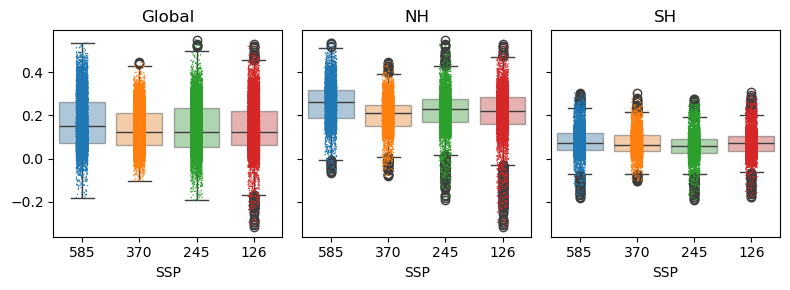

In [5]:
### Highlighting warming in northern hemisphere

regions = ['Global','NH','SH']

fig, axs = plt.subplots(1,len(regions), figsize = (8,3), sharey = True)
for j, region in enumerate(regions):
    box_data = pd.DataFrame(columns = scenarios)

    colors = ['tab:blue','tab:orange','tab:green','tab:red'] 

    mapping = {585: [2,3], 370: [2,3], 245: [3,4], 126: [0,1]}

    for i, (ssp, mode) in enumerate(dmdcs_hankel.items()):
        X0 = get_real(dmdcs_hankel, ssp, mapping[ssp])
        cropped_data = crop_data(X0, lat_data, lon_data, region)
        box_data[ssp] = cropped_data.values.flatten()

    ax = sns.boxplot(data=box_data, boxprops={'alpha': 0.4}, 
                     order = scenarios, palette = colors[::-1],
                     ax = axs[j])
    sns.stripplot(data=box_data, ax=ax, size = 1, palette = colors[::-1])
    ax.set_title(region)
    ax.set_xlabel('SSP')

plt.tight_layout()
plt.savefig('plots/warming_trend_hemisphere_boxplot.pdf')


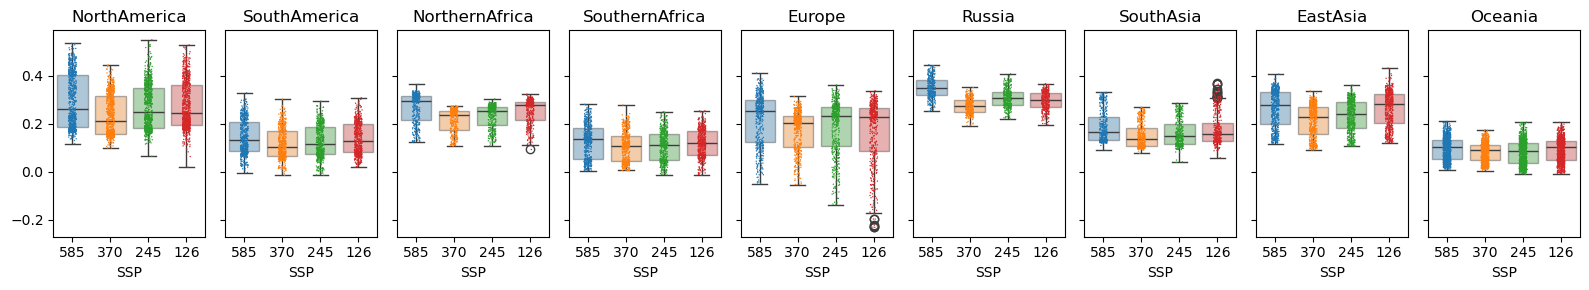

In [6]:
regions = [ 'NorthAmerica', 'SouthAmerica', 'NorthernAfrica', 'SouthernAfrica',
           'Europe','Russia','SouthAsia','EastAsia','Oceania']
fig, axs = plt.subplots(1,len(regions), figsize = (16,3), sharey = True)
for j, region in enumerate(regions):
    box_data = pd.DataFrame(columns = scenarios)

    colors = ['tab:blue','tab:orange','tab:green','tab:red'] 

    mapping = {585: [2,3], 370: [2,3], 245: [3,4], 126: [0,1]}

    for i, (ssp, mode) in enumerate(dmdcs_hankel.items()):
        X0 = get_real(dmdcs_hankel, ssp, mapping[ssp])
        cropped_data = crop_data(X0, lat_data, lon_data, region)
        box_data[ssp] = cropped_data.values.flatten()

    ax = sns.boxplot(data=box_data, boxprops={'alpha': 0.4}, 
                     order = scenarios, palette = colors[::-1],
                     ax = axs[j])
    sns.stripplot(data=box_data, ax=ax, size = 1, palette = colors[::-1])
    ax.set_title(region)
    ax.set_xlabel('SSP')

plt.tight_layout()
plt.savefig('plots/warming_trend_landmass_boxplot.pdf')


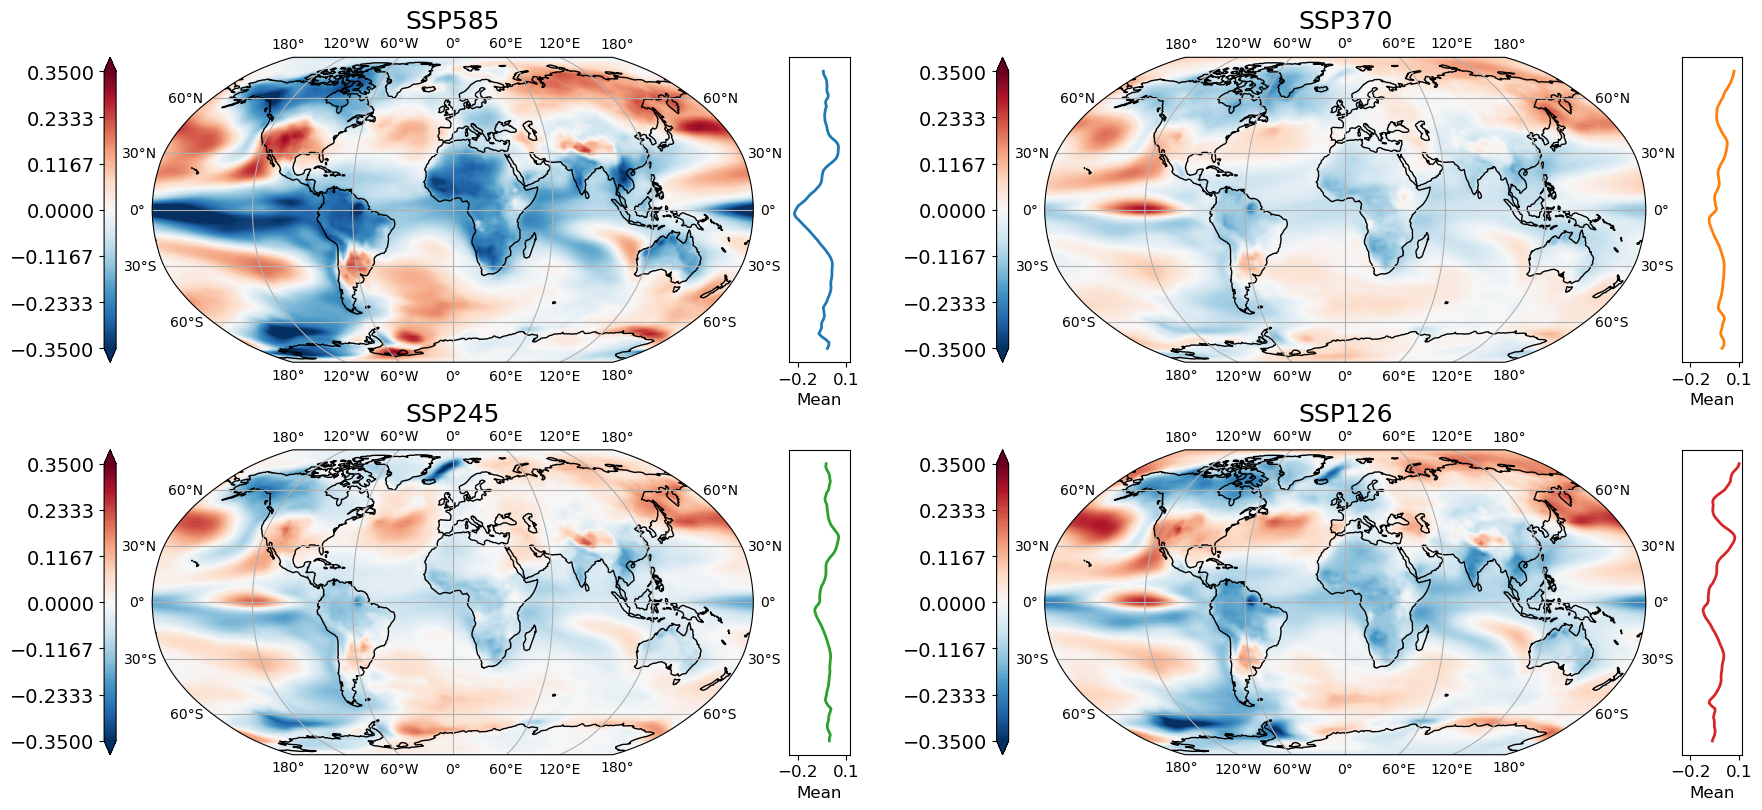

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(18,8), 
                       subplot_kw={'projection': ccrs.Robinson()})

caxs = []
for axi in ax.flatten():
    # caxs.append(axi.inset_axes((1.02, 0, 0.1, 1)))
    caxs.append(axi.inset_axes((1.06, 0, 0.1, 1)))

js = [(0,0),(0,1),(1,0),(1,1)]
mapping = {126: [2,3], 245: [0,1], 370: [0,1], 585: [0,1]}
colors = ['tab:blue','tab:orange','tab:green','tab:red'] 
i=0
for ssp in scenarios:
    dmd = dmdcs_hankel[ssp]
    X0 = 2*np.real(dmd.modes[:,mapping[ssp][0]]*dmd.amplitudes[mapping[ssp][0]]) 
    for j in range(len(js)):
        if i == j:
            a = 1
        else:
            a = 0
        caxs[j].plot(np.mean(np.real(X0).reshape(96, 144), axis = 1), lat_data, color = colors[i], alpha = a, lw = 2)
        caxs[j].set_yticks([])
        caxs[j].set_xlim([-.25,.12])
        caxs[j].set_xticks([-.2,.1])
        caxs[j].set_xlabel('Mean',fontsize=12)
        caxs[j].tick_params(axis='x',labelsize=12)
    i+=1


i=0
for i, ssp in enumerate(scenarios):
    dmd = dmdcs_hankel[ssp]
    X0 = 2*np.real(dmd.modes[:,mapping[ssp][0]]*dmd.amplitudes[mapping[ssp][0]]) 
    plotmap(X0, ax[js[i]], .35) #did not use max val here because the max val is >1 and washes out the color
    ax[js[i]].set_title(f"SSP{ssp}", fontdict = {'fontsize':18})
    i+=1

plt.tight_layout()
plt.savefig('plots/enso.pdf', bbox_inches = 'tight')

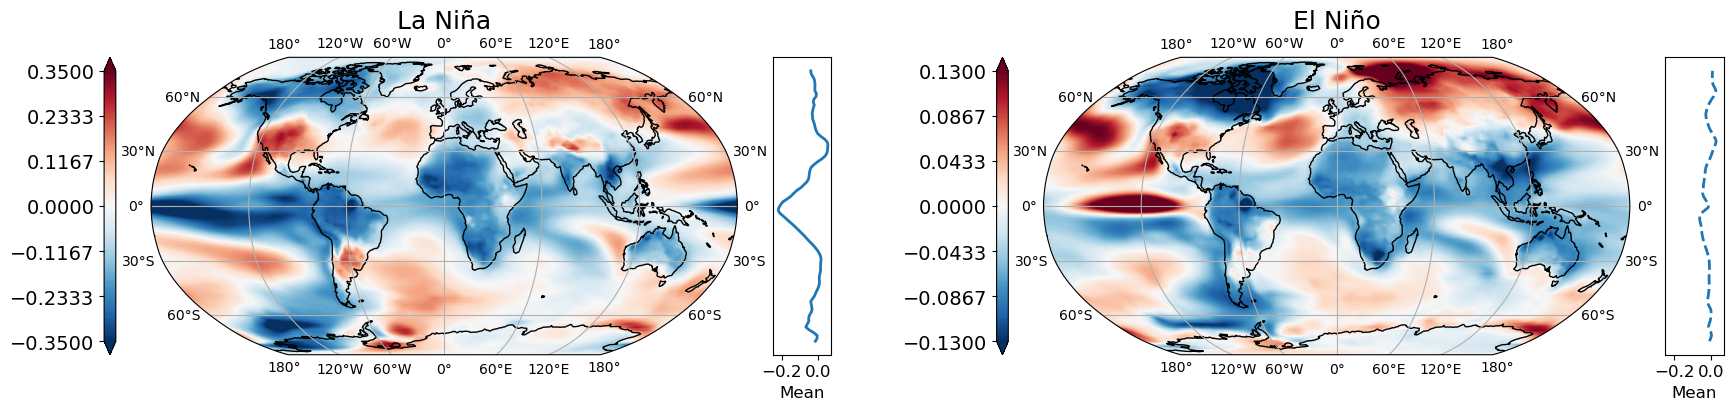

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,4), 
                       subplot_kw={'projection': ccrs.Robinson()})

caxs = []
for axi in ax.flatten():
    # caxs.append(axi.inset_axes((1.02, 0, 0.1, 1)))
    caxs.append(axi.inset_axes((1.06, 0, 0.1, 1)))

ssp = 585

dmd = dmdcs_hankel[ssp]

js = [(0,0),(0,1),(1,0),(1,1)]
mapping = {126: [2,3], 245: [0,1], 370: [0,1], 585: [0,1]}
linestyles = ['solid','dashed'] 
for pwr in range(2):
    X0 = 2*np.real(dmd.modes[:,mapping[ssp][0]]*(dmd.eigs[mapping[ssp][0]]) **pwr*dmd.amplitudes[mapping[ssp][0]]) 
    for j in range(2):
        if pwr == j:
            a = 1
        else:
            a = 0
        caxs[j].plot(np.mean(np.real(X0).reshape(96, 144), axis = 1), lat_data, color = 'tab:blue', alpha = a, lw = 2, linestyle = linestyles[pwr])
        caxs[j].set_yticks([])
        caxs[j].set_xlim([-.25,.07])
        caxs[j].set_xticks([-.2,0])
        caxs[j].set_xlabel('Mean',fontsize=12)
        caxs[j].tick_params(axis='x',labelsize=12)

for pwr, c_max in zip([0,1],[.35,.13]):
    dmd = dmdcs_hankel[ssp]
    X0 = 2*np.real(dmd.modes[:,mapping[ssp][0]]*(dmd.eigs[mapping[ssp][0]]) **pwr*dmd.amplitudes[mapping[ssp][0]]) 
    plotmap(X0, ax[pwr], c_max) #did not use max val here because the max val is >1 and washes out the color
    module1 = np.real(dmdcs_hankel[ssp].eigs[mapping[ssp][0]])
    module2 = np.imag(dmdcs_hankel[ssp].eigs[mapping[ssp][0]])

# plt.suptitle('SSP585', fontsize=18)
ax[0].set_title(r"La Niña", fontdict = {'fontsize':18})
ax[1].set_title(r"El Niño", fontdict = {'fontsize':18})
plt.tight_layout()
plt.savefig('plots/enso_ssp585.pdf', bbox_inches = 'tight')

585
0.18436056955004415
370
0.16333956501395724
245
0.13096061361552164
126
0.14838246292676788


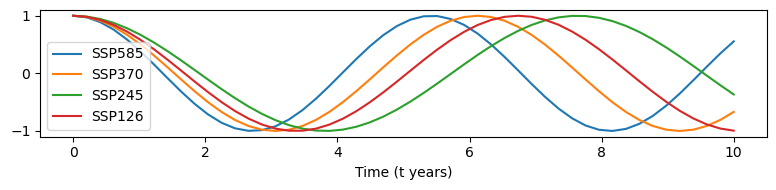

In [9]:
#frequency of oscillation
mapping = {126: 2, 245: 0, 370: 0, 585: 0}

for i, (ssp,dmd) in enumerate(dmdcs_hankel.items()):
    m = mapping[ssp]
    print(ssp)
    print(np.real(-1j*np.log(dmd.eigs[m]/np.abs(dmd.eigs[m]))/(2*np.pi)))

#frequency of oscillation
plt.figure(figsize = (8,2))
mapping = {126: 2, 245: 0, 370: 0, 585: 0}
xs = np.linspace(0,10,50)
for i, (ssp,dmd) in enumerate(dmdcs_hankel.items()):
    m = mapping[ssp]
    plt.plot(xs, np.real(np.exp(xs*np.log(dmd.eigs[m]/np.abs(dmd.eigs[m])))), label = f'SSP{ssp}')

plt.legend()
plt.xlabel('Time (t years)')
# plt.ylabel(r'$e^{i \omega_m t}$')
plt.tight_layout()
plt.savefig('plots/eval_oscillation.pdf')

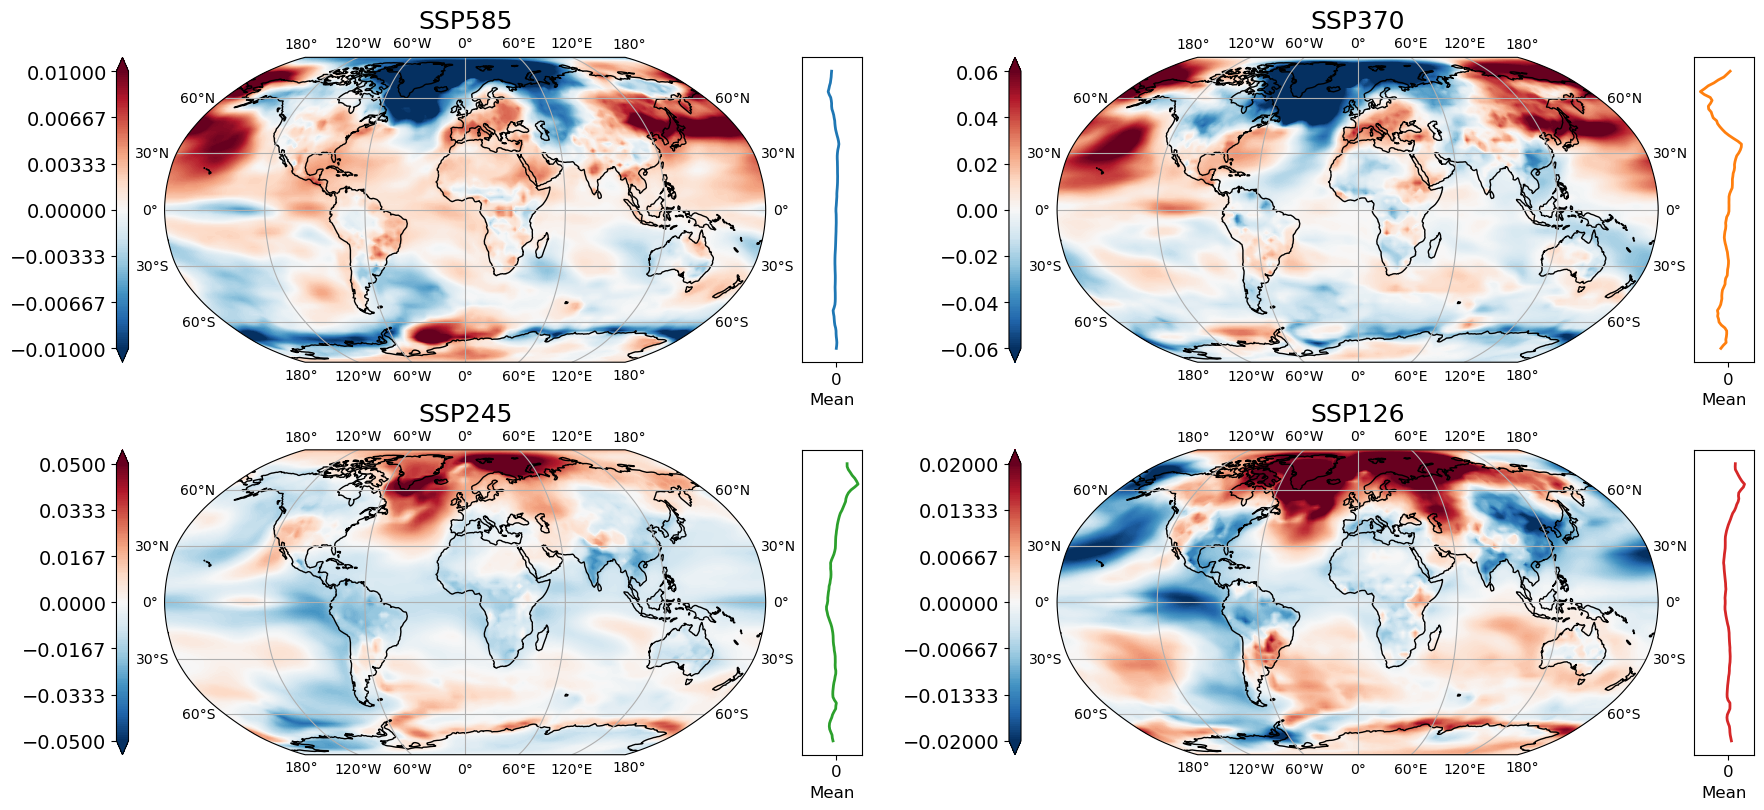

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(18,8), 
                       subplot_kw={'projection': ccrs.Robinson()})

mapping = {126: 4, 245: 2, 370: 4, 585: 4}

caxs = []
for axi in ax.flatten():
    # caxs.append(axi.inset_axes((1.02, 0, 0.1, 1)))
    caxs.append(axi.inset_axes((1.06, 0, 0.1, 1)))

js = [(0,0),(0,1),(1,0),(1,1)]
colors = ['tab:blue','tab:orange','tab:green','tab:red'] 
for i, (ssp, mode) in enumerate(dmdcs_hankel.items()):
    X0 = get_real(dmdcs_hankel, ssp, mapping[ssp])
    for j in range(len(js)):
        if i == j:
            a = 1
        else:
            a = 0
        caxs[j].plot(np.mean(np.real(X0).reshape(96, 144), axis = 1), lat_data, color = colors[i], alpha = a, lw = 2)
        caxs[j].set_yticks([])
        caxs[j].set_xlim([-.048,.037])
        caxs[j].set_xticks([0])
        caxs[j].set_xlabel('Mean',fontsize=12)
        caxs[j].tick_params(axis='x',labelsize=12)

amax = max([np.max([get_real(dmdcs_hankel, ssp, mode).max(), -get_real(dmdcs_hankel, ssp, mode).min()]) for (ssp, mode) in mapping.items()])
c_maxs = [.01,.06,.05,.02]
for i, (ssp, mode) in enumerate(dmdcs_hankel.items()):
    plotmap(get_real(dmdcs_hankel, ssp, mapping[ssp]), ax[js[i]], c_maxs[i])
    module = np.abs(dmdcs_hankel[ssp].eigs[mapping[ssp]])
    # ax[js[i]].set_title(r"SSP{ssp} - |$\lambda$| = {module:.2f}".format(ssp=ssp,  module=module),
    #                     fontdict = {'fontsize':18})
    ax[js[i]].set_title(f"SSP{ssp}",
                        fontdict = {'fontsize':18})

plt.tight_layout()


plt.savefig('plots/unknown_mode.pdf', bbox_inches = 'tight')
